### Simple Multi AI agent Architecture

In [1]:
import os
from typing import TypedDict, Annotated, List, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [3]:
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

In [4]:
## Define the state
class AgentState(MessagesState):
    next_agent:str #which agent should go next 

In [5]:
# Create simple tools
@tool
def search_web(query: str) -> str:
    """Search the web for information."""
    # Using Tavily for web search
    search = TavilySearchResults(max_results=3)
    results = search.invoke(query)
    return str(results)

@tool
def write_summary(content: str) -> str:
    """Write a summary of the provided content."""
    # Simple summary generation
    summary = f"Summary of findings:\n\n{content[:500]}..."
    return summary

In [6]:
from langchain.chat_models import init_chat_model
llm=init_chat_model("groq:meta-llama/llama-4-maverick-17b-128e-instruct")
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x7f741abaee90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f741abaeda0>, model_name='meta-llama/llama-4-maverick-17b-128e-instruct', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
# Define agent functions (simpler approach)
def researcher_agent(state: AgentState):
    """Researcher agent that searches for information"""
    
    messages = state["messages"]
    
    # Add system message for context
    system_msg = SystemMessage(content="You are a research assistant. Use the search_web tool to find information about the user's request.")
    
    # Call LLM with tools
    researcher_llm = llm.bind_tools([search_web])
    response = researcher_llm.invoke([system_msg] + messages)
    
    # Return the response and route to writer
    return {
        "messages": [response],
        "next_agent": "writer"
    }

In [8]:
def writer_agent(state: AgentState):
    """Writer agent that creates summaries"""
    
    messages = state["messages"]
    
    # Add system message
    system_msg = SystemMessage(content="You are a technical writer. Review the conversation and create a clear, concise summary of the findings.")
    
    # Simple completion without tools
    response = llm.invoke([system_msg] + messages)
    
    return {
        "messages": [response],
        "next_agent": "end"
    }

In [9]:
# Tool executor node
def execute_tools(state: AgentState):
    """Execute any pending tool calls"""
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if there are tool calls to execute
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        # Create tool node and execute
        tool_node = ToolNode([search_web, write_summary])
        response = tool_node.invoke(state)
        return response
    
    # No tools to execute
    return state

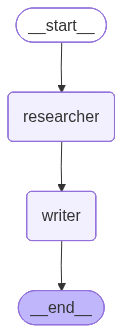

In [10]:
# Build graph
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("researcher", researcher_agent)
workflow.add_node("writer", writer_agent)

# Define flow
workflow.set_entry_point("researcher")
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer", END)
final_workflow=workflow.compile()

final_workflow

In [11]:
response=final_workflow.invoke({"messages":"Reasearch about the usecase of agentic ai in business"})


In [12]:
response["messages"][-1].content

" I'll review the conversation and provide a summary of the findings on the use cases of Agentic AI in business.\n\n**Summary:**\nAgentic AI, also known as autonomous or agent-based AI, refers to AI systems that can act independently, make decisions, and take actions on behalf of humans. The use cases of Agentic AI in business are diverse and continue to grow. Some of the key findings include:\n\n1. **Customer Service**: Agentic AI-powered chatbots and virtual assistants are being used to provide 24/7 customer support, answering queries, and resolving issues.\n2. **Predictive Maintenance**: Agentic AI is used in industries like manufacturing, oil and gas, and healthcare to predict equipment failures, reducing downtime and increasing overall efficiency.\n3. **Supply Chain Optimization**: Agentic AI is used to optimize supply chain operations, such as demand forecasting, inventory management, and logistics optimization.\n4. **Marketing Automation**: Agentic AI is used to automate marketi

## Supervise Multi AI Agent Architecture

In [13]:
from typing import TypedDict, Annotated, List, Literal, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
import random
from datetime import datetime

In [14]:
# ===================================
# State Definition
# ===================================

class SupervisorState(MessagesState):
    """State for the multi-agent system"""
    next_agent: str = ""
    research_data: str = ""
    analysis: str = ""
    final_report: str = ""
    task_complete: bool = False
    current_task: str = ""

In [15]:
# ===================================
# Supervisor with Groq LLM
# ===================================
from langchain_core.prompts import ChatPromptTemplate
def create_supervisor_chain():
    """Creates the supervisor decision chain"""
    
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a supervisor managing a team of agents:
        
1. Researcher - Gathers information and data
2. Analyst - Analyzes data and provides insights  
3. Writer - Creates reports and summaries

Based on the current state and conversation, decide which agent should work next.
If the task is complete, respond with 'DONE'.

Current state:
- Has research data: {has_research}
- Has analysis: {has_analysis}
- Has report: {has_report}

Respond with ONLY the agent name (researcher/analyst/writer) or 'DONE'.
"""),
        ("human", "{task}")
    ])
    
    return supervisor_prompt | llm

In [16]:
def supervisor_agent(state: SupervisorState) -> Dict:
    """Supervisor decides next agent using Groq LLM"""
    
    messages = state["messages"]
    task = messages[-1].content if messages else "No task"
    
    # Check what's been completed
    has_research = bool(state.get("research_data", ""))
    has_analysis = bool(state.get("analysis", ""))
    has_report = bool(state.get("final_report", ""))
    
    # Get LLM decision
    chain = create_supervisor_chain()
    decision = chain.invoke({
        "task": task,
        "has_research": has_research,
        "has_analysis": has_analysis,
        "has_report": has_report
    })
    
    # Parse decision
    decision_text = decision.content.strip().lower()
    print(decision_text)
    
    # Determine next agent
    if "done" in decision_text or has_report:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: All tasks complete! Great work team."
    elif "researcher" in decision_text or not has_research:
        next_agent = "researcher"
        supervisor_msg = "📋 Supervisor: Let's start with research. Assigning to Researcher..."
    elif "analyst" in decision_text or (has_research and not has_analysis):
        next_agent = "analyst"
        supervisor_msg = "📋 Supervisor: Research done. Time for analysis. Assigning to Analyst..."
    elif "writer" in decision_text or (has_analysis and not has_report):
        next_agent = "writer"
        supervisor_msg = "📋 Supervisor: Analysis complete. Let's create the report. Assigning to Writer..."
    else:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: Task seems complete."
    
    return {
        "messages": [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }

In [17]:
# ===================================
# Agent 1: Researcher (using Groq)
# ===================================

def researcher_agent(state: SupervisorState) -> Dict:
    """Researcher uses Groq to gather information"""
    
    task = state.get("current_task", "research topic")
    
    # Create research prompt
    research_prompt = f"""As a research specialist, provide comprehensive information about: {task}

    Include:
    1. Key facts and background
    2. Current trends or developments
    3. Important statistics or data points
    4. Notable examples or case studies
    
    Be concise but thorough."""
    
    # Get research from LLM
    research_response = llm.invoke([HumanMessage(content=research_prompt)])
    research_data = research_response.content
    
    # Create agent message
    agent_message = f"🔍 Researcher: I've completed the research on '{task}'.\n\nKey findings:\n{research_data[:500]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "research_data": research_data,
        "next_agent": "supervisor"
    }

In [18]:
# ===================================
# Agent 2: Analyst (using Groq)
# ===================================

def analyst_agent(state: SupervisorState) -> Dict:
    """Analyst uses Groq to analyze the research"""
    
    research_data = state.get("research_data", "")
    task = state.get("current_task", "")
    
    # Create analysis prompt
    analysis_prompt = f"""As a data analyst, analyze this research data and provide insights:

Research Data:
{research_data}

Provide:
1. Key insights and patterns
2. Strategic implications
3. Risks and opportunities
4. Recommendations

Focus on actionable insights related to: {task}"""
    
    # Get analysis from LLM
    analysis_response = llm.invoke([HumanMessage(content=analysis_prompt)])
    analysis = analysis_response.content
    
    # Create agent message
    agent_message = f"📊 Analyst: I've completed the analysis.\n\nTop insights:\n{analysis[:400]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "analysis": analysis,
        "next_agent": "supervisor"
    }

In [19]:
# ===================================
# Agent 3: Writer (using Groq)
# ===================================

def writer_agent(state: SupervisorState) -> Dict:
    """Writer uses Groq to create final report"""
    
    research_data = state.get("research_data", "")
    analysis = state.get("analysis", "")
    task = state.get("current_task", "")
    
    # Create writing prompt
    writing_prompt = f"""As a professional writer, create an executive report based on:

Task: {task}

Research Findings:
{research_data[:1000]}

Analysis:
{analysis[:1000]}

Create a well-structured report with:
1. Executive Summary
2. Key Findings  
3. Analysis & Insights
4. Recommendations
5. Conclusion

Keep it professional and concise."""
    
    # Get report from LLM
    report_response = llm.invoke([HumanMessage(content=writing_prompt)])
    report = report_response.content
    
    # Create final formatted report
    final_report = f"""
📄 FINAL REPORT
{'='*50}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Topic: {task}
{'='*50}

{report}

{'='*50}
Report compiled by Multi-Agent AI System powered by Groq
"""
    
    return {
        "messages": [AIMessage(content=f"✍️ Writer: Report complete! See below for the full document.")],
        "final_report": final_report,
        "next_agent": "supervisor",
        "task_complete": True
    }

In [20]:
# ===================================
# Router Function
# ===================================

def router(state: SupervisorState) -> Literal["supervisor", "researcher", "analyst", "writer", "__end__"]:
    """Routes to next agent based on state"""
    
    next_agent = state.get("next_agent", "supervisor")
    
    if next_agent == "end" or state.get("task_complete", False):
        return END
        
    if next_agent in ["supervisor", "researcher", "analyst", "writer"]:
        return next_agent
        
    return "supervisor"

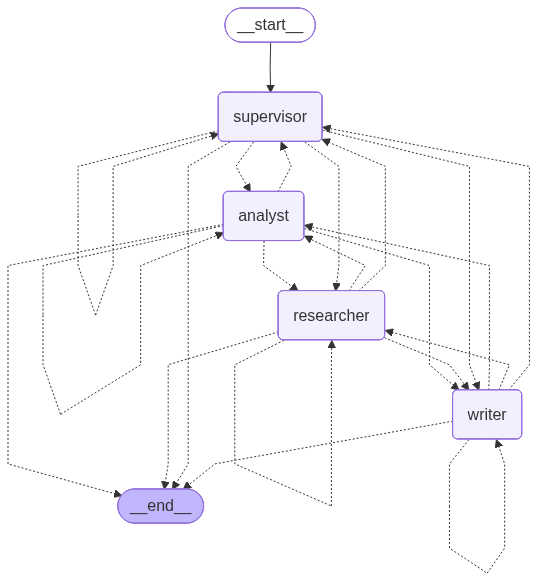

In [22]:
# Create workflow
workflow = StateGraph(SupervisorState)

# Add nodes
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("researcher", researcher_agent)
workflow.add_node("analyst", analyst_agent)
workflow.add_node("writer", writer_agent)

# Set entry point
workflow.set_entry_point("supervisor")

# Add routing
for node in ["supervisor", "researcher", "analyst", "writer"]:
    workflow.add_conditional_edges(
        node,
        router,
        {
            "supervisor": "supervisor",
            "researcher": "researcher",
            "analyst": "analyst",
            "writer": "writer",
            END: END
        }
    )

graph=workflow.compile()
graph

In [23]:
response=graph.invoke(HumanMessage(content="What are the benefits and risks of AI in healthcare?"))

researcher
analyst
writer


In [24]:
response['final_report']

'\n📄 FINAL REPORT\n==================================================\nGenerated: 2025-12-09 15:19\nTopic: 📊 Analyst: I\'ve completed the analysis.\n\nTop insights:\nBased on the provided research data on "Renewable Energy," I\'ll analyze the information and provide insights.\n\n**Key Insights and Patterns:**\n\n1. **Growing investment in renewable energy**: The data indicates a significant global investment in renewable energy, reaching $1.3 trillion over the past decade, with solar energy accounting for 62% of the total.\n2. **Increasing capacity and employment**:...\n==================================================\n\n**Executive Report: Renewable Energy Insights and Strategic Recommendations**\n\n**Executive Summary**\n\nThis report provides an in-depth analysis of the renewable energy sector, highlighting key trends, insights, and strategic recommendations. Our analysis indicates a significant global investment in renewable energy, reaching $1.3 trillion over the past decade, wi